## Plot distributed mass balance from XGBoost predictions

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import seaborn as sns
from pyproj import Proj, transform
from pyproj import Transformer



## Helpers

In [188]:
def oggmToWgs84(ds):
    # Define the Swiss coordinate system (EPSG:2056) and WGS84 (EPSG:4326)
    #transformer = pyproj.Transformer.from_proj(gdir.grid.proj,
    #                                        salem.wgs84,
    #                                        always_xy=True)
    proj4_string = ds.attrs.get('pyproj_srs')

    # Define source and target projections
    source_proj = proj4_string
    target_proj = 'EPSG:4326'  # WGS84 latitude and longitude

    # Create a transformer object
    transformer = Transformer.from_proj(source_proj, target_proj, always_xy=True)

    # Get the Swiss x and y coordinates from the dataset
    x_coords = ds['x'].values
    y_coords = ds['y'].values

    # Create a meshgrid for all x, y coordinate pairs
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)

    # Flatten the meshgrid arrays for transformation
    x_flat = x_mesh.ravel()
    y_flat = y_mesh.ravel()

    # Transform the flattened coordinates
    lon_flat, lat_flat = transformer.transform(x_flat, y_flat)

    # Reshape transformed coordinates back to the original grid shape
    lon = lon_flat.reshape(x_mesh.shape)
    lat = lat_flat.reshape(y_mesh.shape)
    
    # Extract unique 1D coordinates for lat and lon
    lon_1d = lon[0, :]  # Take the first row for unique longitudes along x-axis
    lat_1d = lat[:, 0]  # Take the first column for unique latitudes along y-axis

    # Assign the 1D coordinates to x and y dimensions
    ds = ds.assign_coords(longitude=("x", lon_1d), latitude=("y", lat_1d))

    # Swap x and y dimensions with lon and lat
    ds = ds.swap_dims({"x": "longitude", "y": "latitude"})

    # Optionally, drop the old x and y coordinates if no longer needed
    ds = ds.drop_vars(["x", "y"])
    
    return ds

In [189]:
def predXarray(ds, df_pred, B_type):
    glacier_indices = np.where(ds['glacier_mask'].values == 1)
    pred_masked = ds.glacier_mask.values
    
    # set pred_masked to nan where 0
    pred_masked = np.where(pred_masked == 0, np.nan, pred_masked)
    for i, (x_index, y_index) in enumerate(zip(glacier_indices[0], glacier_indices[1])):
        if B_type == 'Ba':
            pred_masked[x_index, y_index] = df_pred.iloc[i].Ba_pred
        elif B_type == 'Bw':
            pred_masked[x_index, y_index] = df_pred.iloc[i].Bw_pred
        elif B_type == 'Bs':
            pred_masked[x_index, y_index] = df_pred.iloc[i].Bs_pred
        elif B_type == 'prec':
            pred_masked[x_index, y_index] = df_pred.iloc[i].tp_feb
        elif B_type == 'temp':
            pred_masked[x_index, y_index] = (df_pred.iloc[i].t2m_feb)-273

    pred_masked = np.where(pred_masked == 1, np.nan, pred_masked)
    ds_xy = ds.assign(pred_masked=(('y', 'x'), pred_masked))
    
    # change from oggm to wgs84
    ds_latlon = oggmToWgs84(ds_xy)
    
    return ds_latlon, ds_xy

## Check distributed predictions per glacier

In [263]:
# Get file with glacier predictions
filepath = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'
#filepath = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-25_09-45-30/'

# Har artefacts?
filename = 'pred_00434.csv' # Tunsbergdalsbreen - JA
#filename = 'pred_00449.csv' # Helstugubreen - NEI
#filename = 'pred_01013.csv' # Austre memurubre - NEI
#filename = 'pred_01026.csv' # Cainhavarre - NEI
#filename = 'pred_01258.csv' # Langfjordjøkelen - NEI
#filename = 'pred_01286.csv' # Austdalsbreen - JA, men bare to celler og små forskjeller
#filename = 'pred_01484.csv' # Trollbergdalsbreen - NEI
#filename = 'pred_01598.csv' # Svartisbreen - NEI
#filename = 'pred_02384.csv' # Rundvassbreen - NEI
#filename = 'pred_02650.csv' # Hansebreen - JA, men ikke for alle år
#filename = 'pred_02916.csv' # Bondhusbrea - JA, men bare to celler og små forskjeller
#filename = 'pred_02918.csv' # Svelgjabreen - JA, men bare for en liten del
#filename = 'pred_02920.csv' # Blomstølskarsbreen - JA, men ikke for alle år
#filename = 'pred_02969.csv' # Blomstølskarsbreen - JA, men svakt

df_pred = pd.read_csv(filepath+filename)

In [264]:
df_pred

,RGIID,BREID,altitude,lat,lon,aspect,slope,year,t2m_oct,t2m_nov,...,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor,Ba_pred,Bw_pred,Bs_pred
0,RGI60-08.00434,2320,1849.27540,61.672377,7.006795,5.055655,0.031060,1960,272.332886,267.424286,...,0.001800,0.005921,0.005382,0.004753,0.004346,1362.652086,0.982202,-0.095187,1.524244,-1.619430
1,RGI60-08.00434,2320,1852.24330,61.672377,7.008798,5.099957,0.031047,1960,272.332886,267.424286,...,0.001800,0.005921,0.005382,0.004753,0.004346,1362.652086,0.982010,0.252224,1.703576,-1.451352
2,RGI60-08.00434,2320,1855.25150,61.672376,7.010800,5.102583,0.031061,1960,272.332886,267.424286,...,0.001800,0.005921,0.005382,0.004753,0.004346,1362.652086,0.981713,0.267807,1.712666,-1.444859
3,RGI60-08.00434,2320,1858.59530,61.672376,7.012802,5.071776,0.029965,1960,272.332886,267.424286,...,0.001800,0.005921,0.005382,0.004753,0.004346,1362.652086,0.982326,-0.006651,1.551835,-1.558487
4,RGI60-08.00434,2320,1861.61100,61.672376,7.014804,5.016292,0.026561,1960,272.332886,267.424286,...,0.001800,0.005921,0.005382,0.004753,0.004346,1362.652086,0.982965,-0.042290,1.551835,-1.594126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262007,RGI60-08.00434,2320,525.69730,61.535272,7.144307,1.474188,0.044679,2021,275.257843,272.619080,...,0.001479,0.003820,0.002582,0.002353,0.004651,918.443745,0.710373,-12.625033,-2.620194,-10.004840
262008,RGI60-08.00434,2320,532.17230,61.535270,7.146300,4.859687,0.065517,2021,275.916016,273.271912,...,0.001379,0.003591,0.002522,0.002381,0.004576,815.226096,0.701885,-10.978559,-1.806538,-9.172021
262009,RGI60-08.00434,2320,529.37134,61.534321,7.144302,1.294269,0.044232,2021,275.257843,272.619080,...,0.001479,0.003820,0.002582,0.002353,0.004651,918.443745,0.714774,-12.577177,-2.571081,-10.006097
262010,RGI60-08.00434,2320,532.22064,61.534318,7.146296,5.032121,0.109601,2021,275.916016,273.271912,...,0.001379,0.003591,0.002522,0.002381,0.004576,815.226096,0.701726,-11.079905,-1.834065,-9.245840


In [265]:
filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.00434/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.00449/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.01013/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.01026/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.01258/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.01286/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.01484/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.01598/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.02384/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.02650/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.02916/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.02918/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.02920/'
#filepath_mask = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test/RGI60-08.02969/'


filename_mask = 'gridded_data_svf.nc'

with xr.open_dataset(filepath_mask + filename_mask) as ds_out:
    ds = ds_out

In [266]:
ds

<xarray.Dataset>
Dimensions:                  (x: 128, y: 166)
Coordinates:
  * x                        (x) float32 -4.092e+03 -3.986e+03 ... 9.37e+03
  * y                        (y) float32 6.839e+06 6.839e+06 ... 6.821e+06
Data variables: (12/21)
    topo                     (y, x) float32 ...
    topo_smoothed            (y, x) float32 ...
    topo_valid_mask          (y, x) int8 ...
    glacier_mask             (y, x) int8 ...
    glacier_ext              (y, x) int8 ...
    consensus_ice_thickness  (y, x) float32 ...
    ...                       ...
    slope_factor             (y, x) float32 ...
    dis_from_border          (y, x) float32 ...
    catchment_area           (y, x) float32 ...
    lin_mb_above_z           (y, x) float32 ...
    oggm_mb_above_z          (y, x) float32 ...
    skyview_factor           (y, x) float32 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=6.998 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1952.437
    min_h_dem:      239.74004
    max_h_glacier:  1922.0928
    min_h_glacier:  525.6973

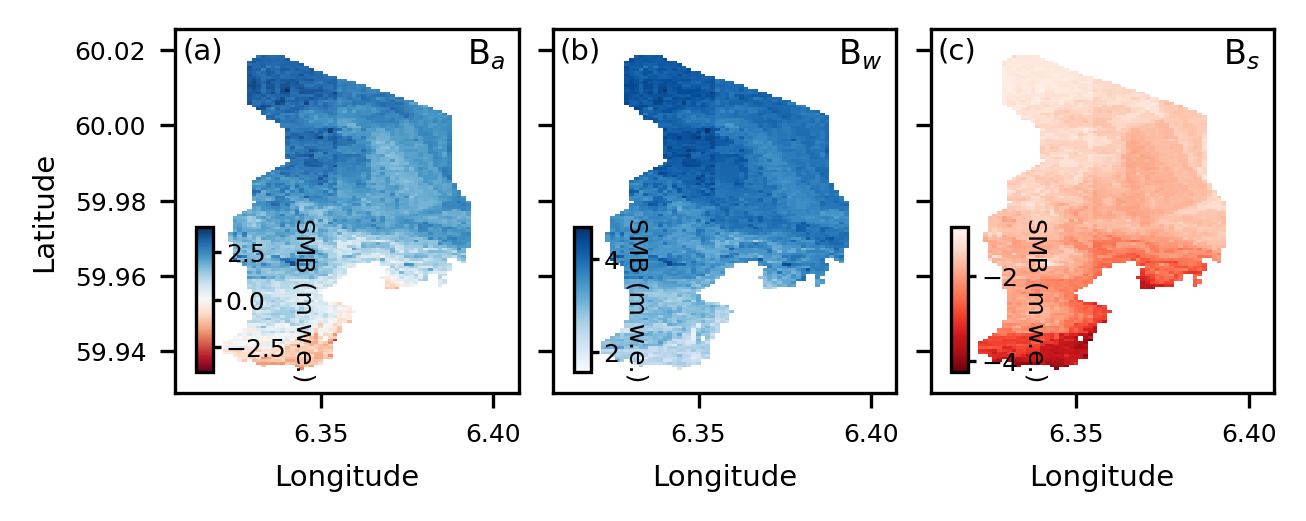

In [262]:
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def get_cmap_part(cmap_name, part):
    cmap = plt.get_cmap(cmap_name)
    if part == 'blue':
        colors = cmap(np.linspace(0.5, 1, 256))  # Upper half for blue
    elif part == 'red':
        colors = cmap(np.linspace(0, 0.5, 256))  # Lower half for red
    else:
        raise ValueError("part must be 'blue' or 'red'")
        
    new_cmap = LinearSegmentedColormap.from_list(f"{cmap_name}_{part}", colors)
    return new_cmap
    
year = 2015
pred_y_annual = df_pred[df_pred.year == year].drop(['year'], axis=1)

B_type = ['Ba', 'Bw', 'Bs']

cm=1/2.54

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12*cm, 4*cm), dpi=300, sharex=True, sharey=True)

for i in range(3):
            
    type_ = B_type[i]

    # Create color maps for 'red' and 'blue' parts of 'RdBu'
    if type_ == 'Ba':
        cmap = 'RdBu'
        color_part = None
    elif type_ == 'Bw':
        cmap = 'Blues'
        color_part = None  # Use blue part
    elif type_ == 'Bs':
        cmap = 'Reds_r'
        color_part = 'red'  # Use red part
    
    #if color_part:
    #    cmap = get_cmap_part(cmap, color_part)

    ds_pred_annual_latlon, ds_pred_annual_xy = predXarray(ds, pred_y_annual, B_type[i])
    pred_data = ds_pred_annual_latlon.pred_masked.values
    #vmin = np.nanmin(pred_data)
    #vmax = np.nanmax(pred_data)
    #if vmax>0:
    #    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    #else:
        #norm = Normalize(vmin=vmin, vmax=vmax)
        #norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=1)

    
    if type_ == 'Ba':
        im=ds_pred_annual_latlon.pred_masked.plot(cmap=cmap,ax=axes[i], add_colorbar=False)
        # Add a colorbar inside the subplot in the lower left corner
        cbar_ax = inset_axes(axes[i],
                         width="5%",  # width: 40% of parent_bbox width
                         height="40%",  # height: 5% of parent_bbox height
                         loc='lower left',
                         borderpad=0.5)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [-8, -4, 0, 4, 8]  # Adjust this array for desired tick positions
        #tick_labels = [f"{tick:.2f}" for tick in ticks]  # Optional: Custom tick labels
        #cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=6, length=2, pad=1)
        cbar.set_label('SMB (m w.e.)', fontsize=6, labelpad=7, rotation=270)
        
    elif type_ == 'Bw':
        im=ds_pred_annual_latlon.pred_masked.plot(cmap=cmap,ax=axes[i], add_colorbar=False)
        cbar_ax = inset_axes(axes[i],
                         width="5%",  # width: 40% of parent_bbox width
                         height="40%",  # height: 5% of parent_bbox height
                         loc='lower left',
                         borderpad=0.5)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [-3, 0, 3]  # Adjust this array for desired tick positions
        #tick_labels = [f"{tick:.2f}" for tick in ticks]  # Optional: Custom tick labels
        #cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=6, length=2, pad=1)
        cbar.set_label('SMB (m w.e.)', fontsize=6, labelpad=7, rotation=270)
        
    elif type_ == 'Bs':
        im=ds_pred_annual_latlon.pred_masked.plot(cmap=cmap,ax=axes[i], add_colorbar=False)
        cbar_ax = inset_axes(axes[i],
                         width="5%",  # width: 40% of parent_bbox width
                         height="40%",  # height: 5% of parent_bbox height
                         loc='lower left',
                         borderpad=0.5)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = np.linspace(-8, -2, 4)  # Adjust this array for desired tick positions
        #tick_labels = [f"{tick:.2f}" for tick in ticks]  # Optional: Custom tick labels
        #cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=6, length=2, pad=1)
        cbar.set_label('SMB (m w.e.)', fontsize=6, labelpad=7, rotation=270)
        
    #axes[i].set_title(f'{type_}', fontsize=7.5)
    axes[i].set_xlabel('Longitude', fontsize=7)
    axes[i].set_ylabel('')
    axes[0].set_ylabel('Latitude', fontsize=7)

    annotation_label = f"({chr(97 + i)})"  # 97 is ASCII for 'a'
    axes[i].text(0.02, 0.98, annotation_label, transform=axes[i].transAxes, fontsize=7,
            verticalalignment='top', horizontalalignment='left')
    #axes[0].set_ticks([)

    axes[i].tick_params(labelsize=7)
    for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        label.set_fontsize(6)

    # Annotate the subplot with B_a, B_s, B_w in the upper right corner
    subscript_label = f"B$_{{{type_[1]}}}$"
    axes[i].text(0.96, 0.98, subscript_label, transform=axes[i].transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right')

plt.subplots_adjust(wspace=0.1)
#plt.tight_layout()

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'smb_distr_tunsbergdal_2000.pdf', format='pdf', bbox_inches='tight')

plt.show()

## Plot Tunsbergdalsbreen

In [267]:
ds_latlon = oggmToWgs84(ds)


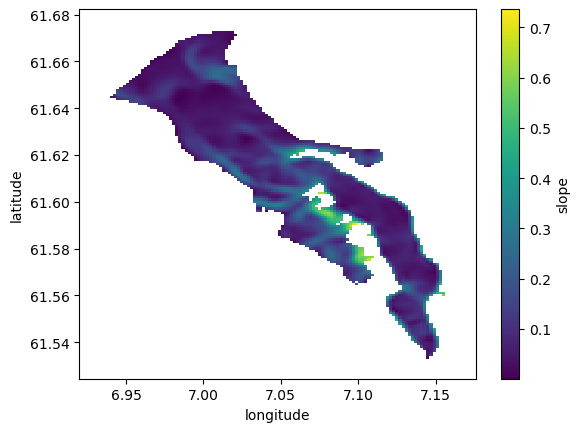

In [268]:
mask = ds_latlon.glacier_mask.values.astype(float)
mask[mask<1]=np.nan

slope_masked = ds_latlon.slope*mask
slope_masked.plot()

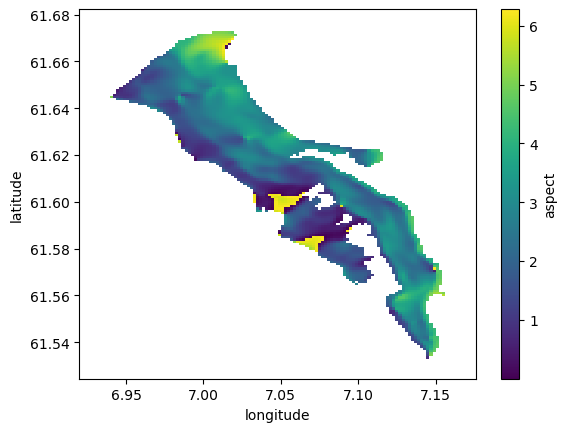

In [269]:
aspect_masked = ds_latlon.aspect*mask
aspect_masked.plot()

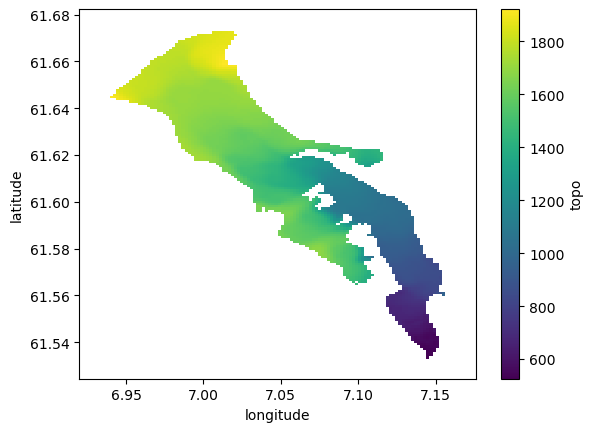

In [270]:
elev_masked = ds_latlon.topo*mask
elev_masked.plot()

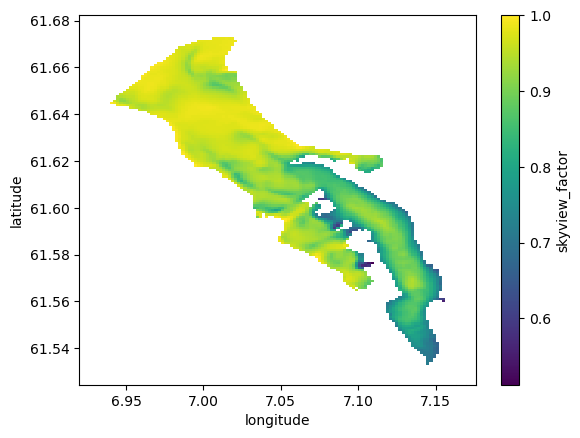

In [271]:
svf_masked = ds_latlon.skyview_factor*mask
svf_masked.plot()

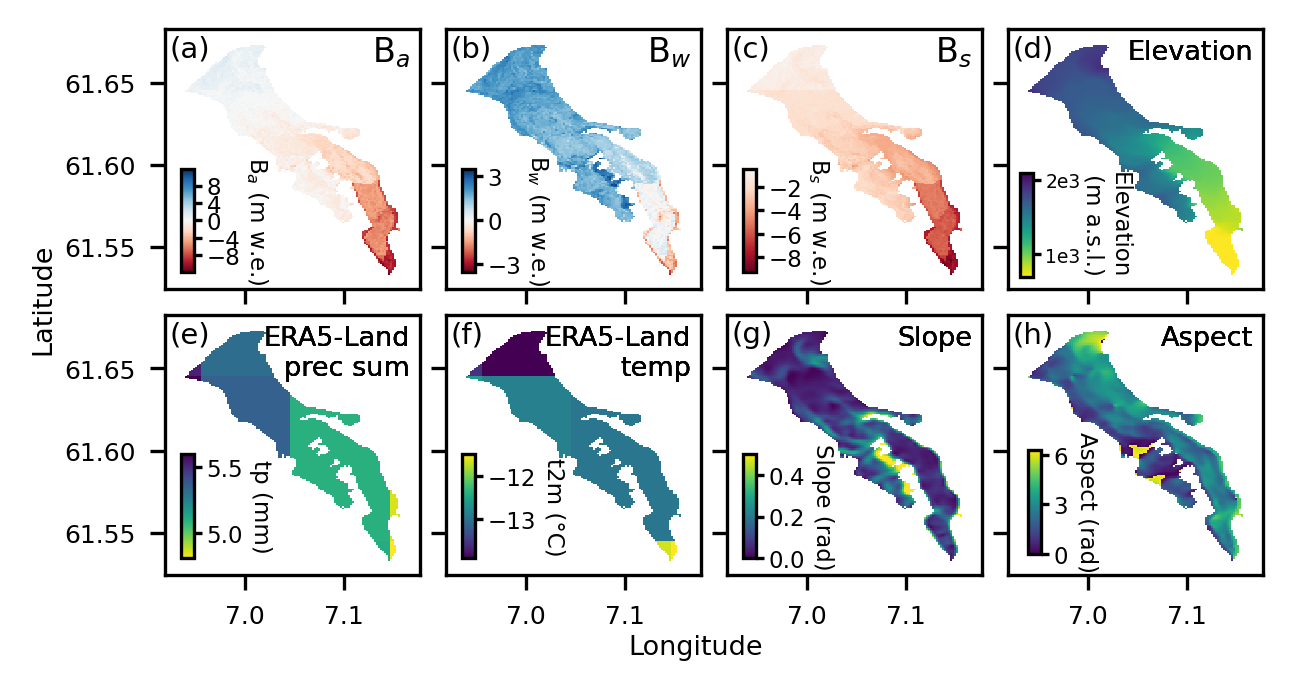

In [272]:
# Figure above but with topographical features
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

def get_cmap_part(cmap_name, part):
    cmap = plt.get_cmap(cmap_name)
    if part == 'blue':
        colors = cmap(np.linspace(0.5, 1, 256))  # Upper half for blue
    elif part == 'red':
        colors = cmap(np.linspace(0, 0.5, 256))  # Lower half for red
    else:
        raise ValueError("part must be 'blue' or 'red'")
        
    new_cmap = LinearSegmentedColormap.from_list(f"{cmap_name}_{part}", colors)
    return new_cmap
    
year = 2001
pred_y_annual = df_pred[df_pred.year == year].drop(['year'], axis=1)

B_type = ['Ba', 'Bw', 'Bs']

cm=1/2.54

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12*cm, 6*cm), dpi=300, sharex=True, sharey=True)

for i in range(3):
            
    type_ = B_type[i]

    # Create color maps for 'red' and 'blue' parts of 'RdBu'
    if type_ == 'Ba':
        cmap = 'RdBu'
        color_part = None
    elif type_ == 'Bw':
        cmap = 'RdBu'
        color_part = None  # Use blue part
    elif type_ == 'Bs':
        cmap = 'RdBu'
        color_part = 'red'  # Use red part
    
    if color_part:
        cmap = get_cmap_part(cmap, color_part)

    ds_pred_annual_latlon, ds_pred_annual_xy = predXarray(ds, pred_y_annual, B_type[i])
    pred_data = ds_pred_annual_latlon.pred_masked.values
    vmin = np.nanmin(pred_data)
    vmax = np.nanmax(pred_data)
    if vmax>0:
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    else:
        norm = Normalize(vmin=vmin, vmax=vmax)
        #norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=1)

    
    if type_ == 'Ba':
        im=ds_pred_annual_latlon.pred_masked.plot(cmap=cmap,ax=axes[0,i], add_colorbar=False)
        cbar_ax = inset_axes(axes[0,i],
                         width="5%", 
                         height="40%",  
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [-8, -4, 0, 4, 8]  
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('B$_{a}$ (m w.e.)', fontsize=5.5, labelpad=7, rotation=270)
        
    elif type_ == 'Bw':
        im=ds_pred_annual_latlon.pred_masked.plot(cmap=cmap,ax=axes[0,i], add_colorbar=False)
        cbar_ax = inset_axes(axes[0,i],
                         width="5%", 
                         height="40%",  
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [-3, 0, 3] 
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('B$_{w}$ (m w.e.)', fontsize=5.5, labelpad=7, rotation=270)
        
    elif type_ == 'Bs':
        im=ds_pred_annual_latlon.pred_masked.plot(cmap=cmap, ax=axes[0,i], add_colorbar=False)
        cbar_ax = inset_axes(axes[0,i],
                         width="5%", 
                         height="40%",
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = np.linspace(-8, -2, 4) 
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('B$_{s}$ (m w.e.)', fontsize=5.5, labelpad=7, rotation=270)
        
    #axes[i].set_title(f'{type_}', fontsize=7.5)
    #axes[i,0].set_xlabel('Longitude', fontsize=7)
    axes[0,i].set_xlabel('')
    axes[0,i].set_ylabel('')
    #axes[0,0].set_ylabel('Latitude', fontsize=7)

    annotation_label = f"({chr(97 + i)})"  # 97 is ASCII for 'a'
    axes[0,i].text(0.02, 0.98, annotation_label, transform=axes[0,i].transAxes, fontsize=7,
            verticalalignment='top', horizontalalignment='left')
    #axes[0].set_ticks([)

    axes[0,i].tick_params(labelsize=6)
    for label in axes[0,i].get_xticklabels() + axes[0,i].get_yticklabels():
        label.set_fontsize(6)

    # Annotate the subplot with B_a, B_s, B_w in the upper right corner
    subscript_label = f"B$_{{{type_[1]}}}$"
    axes[0,i].text(0.96, 0.98, subscript_label, transform=axes[0,i].transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right')
    axes[0,i].set_ylabel('', fontsize=6.5, labelpad=1)

k = 3

im=elev_masked.plot(ax=axes[0,k], cmap='viridis_r',vmin=700, vmax=2100, add_colorbar=False)
cbar_ax = inset_axes(axes[0,k],
                         width="5%", 
                         height="40%",  
                         loc='lower left',
                         borderpad=0.3)
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
ticks = [1000, 2000]  
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(['1e3', '2e3'])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.tick_params(labelsize=4.5, length=2, pad=1)

# Define a function to wrap text
def wrap_text(text, width):
    return "\n".join(wrap(text, width=width))

wrapped_cbar_label_elev = wrap_text('Elevation (m a.s.l.)', 10) 
cbar.set_label(wrapped_cbar_label_elev, fontsize=5.5, labelpad=12, rotation=270)
#cbar.set_label('Elevation (m a.s.l.)', fontsize=5.5, labelpad=7, rotation=270)

axes[0,k].set_ylabel('', fontsize=6.5, labelpad=1)

annotation_label = f"({chr(97 + k)})"  # 97 is ASCII for 'a'
axes[0,k].text(0.02, 0.98, annotation_label, transform=axes[0,k].transAxes, fontsize=7,
            verticalalignment='top', horizontalalignment='left')

for j in range(4):
    if j==0:
        type='prec'
        ds_pred_annual_latlon, ds_pred_annual_xy = predXarray(ds, pred_y_annual, type)
        ds_pred_annual_latlon = ds_pred_annual_latlon*1000
        im=ds_pred_annual_latlon.pred_masked.plot(cmap='viridis_r',ax=axes[1,j], add_colorbar=False)
        cbar_ax = inset_axes(axes[1,j],
                         width="5%", 
                         height="40%",
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        #ticks = np.linspace(-8, -2, 4) 
        #cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('tp (mm)', fontsize=5.5, labelpad=7, rotation=270)

    elif j==1:
        type='temp'
        ds_pred_annual_latlon, ds_pred_annual_xy = predXarray(ds, pred_y_annual, type)
        im=ds_pred_annual_latlon.pred_masked.plot(cmap='viridis',ax=axes[1,j], add_colorbar=False)
        cbar_ax = inset_axes(axes[1,j],
                         width="5%", 
                         height="40%",
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        #ticks = np.linspace(-8, -2, 4) 
        #cbar.set_ticks(ticks)
        #ticks = [-6,-4]  
        #cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('t2m (°C)', fontsize=5.5, labelpad=7, rotation=270)
    
    elif j==2:
        im=slope_masked.plot(ax=axes[1,j], vmin=0, vmax=0.5, add_colorbar=False)
        cbar_ax = inset_axes(axes[1,j],
                         width="5%", 
                         height="40%",  
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [0, 0.2, 0.4]  
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        #wrapped_cbar_label_slope = wrap_text('Slope (rad)', 6) 
        #cbar.set_label(wrapped_cbar_label_slope, fontsize=5.5, labelpad=12, rotation=270)
        cbar.set_label('Slope (rad)', fontsize=5.5, labelpad=7, rotation=270)
        
    elif j==3: 
        im=aspect_masked.plot(ax=axes[1,j], add_colorbar=False)
        cbar_ax = inset_axes(axes[1,j],
                         width="5%",  
                         height="40%", 
                         loc='lower left',
                         borderpad=0.5)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [0, 3, 6]  
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('Aspect (rad)', fontsize=5.5, labelpad=7, rotation=270)

    axes[1,j].grid(False)
    axes[1,j].set_ylabel('')
    axes[1,j].set_xlabel('', fontsize=6.5, labelpad=1)

    axes[1,j].tick_params(labelsize=6)
    for label in axes[1,j].get_xticklabels() + axes[1,j].get_yticklabels():
        label.set_fontsize(6)

    annotation_label = f"({chr(101 + j)})"  # 97 is ASCII for 'a'
    axes[1,j].text(0.02, 0.98, annotation_label, transform=axes[1,j].transAxes, fontsize=7,
            verticalalignment='top', horizontalalignment='left')

    # Your long text
    text = 'ERA5-Land prec sum'
    text2 = 'ERA5-Land temp'

    # Wrap the text with a width
    wrapped_text = "\n".join(wrap(text, width=10))
    wrapped_text2 = "\n".join(wrap(text2, width=10))

    axes[1,0].text(0.96, 0.96, wrapped_text, transform=axes[1,0].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')
    axes[1,1].text(0.96, 0.96, wrapped_text2, transform=axes[1,1].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')
    axes[0,3].text(0.96, 0.96, 'Elevation', transform=axes[0,3].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')
    axes[1,2].text(0.96, 0.96, 'Slope', transform=axes[1,2].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')
    axes[1,3].text(0.96, 0.96, 'Aspect', transform=axes[1,3].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')

    fig.supylabel('Latitude', fontsize=6.5, x=0.03)
    fig.supxlabel('Longitude', fontsize=6.5, y=-0.01)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'smb_distr_tunsbergdal_2000.png', format='png', bbox_inches='tight')

plt.show()

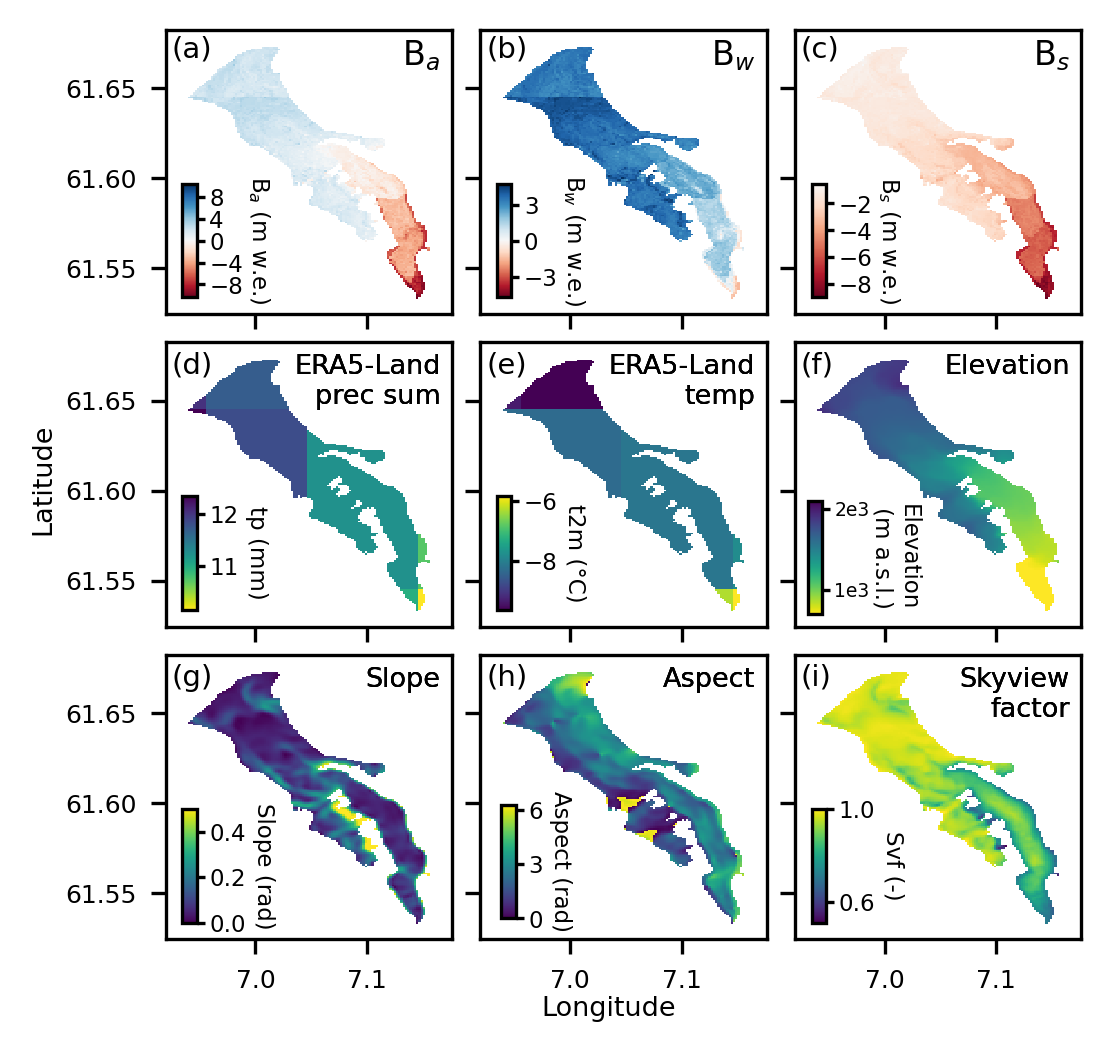

In [118]:
# Figure above but with topographical features
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

def get_cmap_part(cmap_name, part):
    cmap = plt.get_cmap(cmap_name)
    if part == 'blue':
        colors = cmap(np.linspace(0.5, 1, 256))  # Upper half for blue
    elif part == 'red':
        colors = cmap(np.linspace(0, 0.5, 256))  # Lower half for red
    else:
        raise ValueError("part must be 'blue' or 'red'")
        
    new_cmap = LinearSegmentedColormap.from_list(f"{cmap_name}_{part}", colors)
    return new_cmap
    
year = 2000
pred_y_annual = df_pred[df_pred.year == year].drop(['year'], axis=1)

B_type = ['Ba', 'Bw', 'Bs']

cm=1/2.54

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10*cm, 10*cm), dpi=300, sharex=True, sharey=True)

for i in range(3):
            
    type_ = B_type[i]

    # Create color maps for 'red' and 'blue' parts of 'RdBu'
    if type_ == 'Ba':
        cmap = 'RdBu'
        color_part = None
    elif type_ == 'Bw':
        cmap = 'RdBu'
        color_part = None  # Use blue part
    elif type_ == 'Bs':
        cmap = 'RdBu'
        color_part = 'red'  # Use red part
    
    if color_part:
        cmap = get_cmap_part(cmap, color_part)

    ds_pred_annual_latlon, ds_pred_annual_xy = predXarray(ds, pred_y_annual, B_type[i])
    pred_data = ds_pred_annual_latlon.pred_masked.values
    vmin = np.nanmin(pred_data)
    vmax = np.nanmax(pred_data)
    if vmax>0:
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    else:
        norm = Normalize(vmin=vmin, vmax=vmax)
        #norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=1)

    
    if type_ == 'Ba':
        im=ds_pred_annual_latlon.pred_masked.plot(cmap=cmap,ax=axes[0,i], add_colorbar=False)
        cbar_ax = inset_axes(axes[0,i],
                         width="5%", 
                         height="40%",  
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [-8, -4, 0, 4, 8]  
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('B$_{a}$ (m w.e.)', fontsize=5.5, labelpad=7, rotation=270)
        
    elif type_ == 'Bw':
        im=ds_pred_annual_latlon.pred_masked.plot(cmap=cmap,ax=axes[0,i], add_colorbar=False)
        cbar_ax = inset_axes(axes[0,i],
                         width="5%", 
                         height="40%",  
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [-3, 0, 3] 
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('B$_{w}$ (m w.e.)', fontsize=5.5, labelpad=7, rotation=270)
        
    elif type_ == 'Bs':
        im=ds_pred_annual_latlon.pred_masked.plot(cmap=cmap, ax=axes[0,i], add_colorbar=False)
        cbar_ax = inset_axes(axes[0,i],
                         width="5%", 
                         height="40%",
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = np.linspace(-8, -2, 4) 
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('B$_{s}$ (m w.e.)', fontsize=5.5, labelpad=7, rotation=270)
        
    #axes[i].set_title(f'{type_}', fontsize=7.5)
    #axes[i,0].set_xlabel('Longitude', fontsize=7)
    axes[0,i].set_xlabel('')
    axes[0,i].set_ylabel('')
    #axes[0,0].set_ylabel('Latitude', fontsize=7)

    annotation_label = f"({chr(97 + i)})"  # 97 is ASCII for 'a'
    axes[0,i].text(0.02, 0.98, annotation_label, transform=axes[0,i].transAxes, fontsize=7,
            verticalalignment='top', horizontalalignment='left')
    #axes[0].set_ticks([)

    axes[0,i].tick_params(labelsize=6)
    for label in axes[0,i].get_xticklabels() + axes[0,i].get_yticklabels():
        label.set_fontsize(6)

    # Annotate the subplot with B_a, B_s, B_w in the upper right corner
    subscript_label = f"B$_{{{type_[1]}}}$"
    axes[0,i].text(0.96, 0.97, subscript_label, transform=axes[0,i].transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right')
    axes[0,i].set_ylabel('', fontsize=6.5, labelpad=1)

for k in range(3):
    
    if k==0:
        type='prec'
        ds_pred_annual_latlon, ds_pred_annual_xy = predXarray(ds, pred_y_annual, type)
        ds_pred_annual_latlon = ds_pred_annual_latlon*1000
        im=ds_pred_annual_latlon.pred_masked.plot(cmap='viridis_r',ax=axes[1,k], add_colorbar=False)
        cbar_ax = inset_axes(axes[1,k],
                         width="5%", 
                         height="40%",
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        #ticks = np.linspace(-8, -2, 4) 
        #cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('tp (mm)', fontsize=5.5, labelpad=7, rotation=270)

    elif k==1:
        type='temp'
        ds_pred_annual_latlon, ds_pred_annual_xy = predXarray(ds, pred_y_annual, type)
        im=ds_pred_annual_latlon.pred_masked.plot(cmap='viridis',ax=axes[1,k], add_colorbar=False)
        cbar_ax = inset_axes(axes[1,k],
                         width="5%", 
                         height="40%",
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        #ticks = np.linspace(-8, -2, 4) 
        #cbar.set_ticks(ticks)
        #ticks = [-6,-4]  
        #cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('t2m (°C)', fontsize=5.5, labelpad=7, rotation=270)

    elif k==2:
    
        im=elev_masked.plot(ax=axes[1,k], cmap='viridis_r',vmin=700, vmax=2100, add_colorbar=False)
        cbar_ax = inset_axes(axes[1,k],
                         width="5%", 
                         height="40%",  
                         loc='lower left',
                         borderpad=0.3)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [1000, 2000]  
        cbar.set_ticks(ticks)
        cbar.ax.set_yticklabels(['1e3', '2e3'])
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=4.5, length=2, pad=1)

        def wrap_text(text, width):
            return "\n".join(wrap(text, width=width))

        wrapped_cbar_label_elev = wrap_text('Elevation (m a.s.l.)', 10) 
        cbar.set_label(wrapped_cbar_label_elev, fontsize=5.5, labelpad=12, rotation=270)
        #cbar.set_label('Elevation (m a.s.l.)', fontsize=5.5, labelpad=7, rotation=270)

        axes[1,k].set_ylabel('', fontsize=6.5, labelpad=1)

    annotation_label = f"({chr(100 + k)})"  # 97 is ASCII for 'a'
    axes[1,k].text(0.02, 0.97, annotation_label, transform=axes[1,k].transAxes, fontsize=7,
                verticalalignment='top', horizontalalignment='left')

    axes[1,k].grid(False)
    axes[1,k].set_ylabel('')
    axes[1,k].set_xlabel('', fontsize=6.5, labelpad=1)

for j in range(3):
    
    if j==0:
        im=slope_masked.plot(ax=axes[2,j], vmin=0, vmax=0.5, add_colorbar=False)
        cbar_ax = inset_axes(axes[2,j],
                         width="5%", 
                         height="40%",  
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [0, 0.2, 0.4]  
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        #wrapped_cbar_label_slope = wrap_text('Slope (rad)', 6) 
        #cbar.set_label(wrapped_cbar_label_slope, fontsize=5.5, labelpad=12, rotation=270)
        cbar.set_label('Slope (rad)', fontsize=5.5, labelpad=7, rotation=270)
        
    elif j==1: 
        im=aspect_masked.plot(ax=axes[2,j], add_colorbar=False)
        cbar_ax = inset_axes(axes[2,j],
                         width="5%",  
                         height="40%", 
                         loc='lower left',
                         borderpad=0.5)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [0, 3, 6]  
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('Aspect (rad)', fontsize=5.5, labelpad=7, rotation=270)

    elif j==2: 
        im=svf_masked.plot(ax=axes[2,j], add_colorbar=False)
        cbar_ax = inset_axes(axes[2,j],
                         width="5%",  
                         height="40%", 
                         loc='lower left',
                         borderpad=0.4)
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        ticks = [0.6, 1]  
        cbar.set_ticks(ticks)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=5.5, length=2, pad=1)
        cbar.set_label('Svf (-)', fontsize=5.5, labelpad=7, rotation=270)

    axes[2,j].grid(False)
    axes[2,j].set_ylabel('')
    axes[2,j].set_xlabel('', fontsize=6.5, labelpad=1)

    axes[2,j].tick_params(labelsize=6)
    for label in axes[2,j].get_xticklabels() + axes[1,j].get_yticklabels():
        label.set_fontsize(6)

    annotation_label = f"({chr(103 + j)})"  # 97 is ASCII for 'a'
    axes[2,j].text(0.02, 0.97, annotation_label, transform=axes[2,j].transAxes, fontsize=7,
            verticalalignment='top', horizontalalignment='left')

    # Your long text
    text = 'ERA5-Land prec sum'
    text2 = 'ERA5-Land temp'
    text3 = 'Skyview factor'

    # Wrap the text with a width
    wrapped_text = "\n".join(wrap(text, width=10))
    wrapped_text2 = "\n".join(wrap(text2, width=10))
    wrapped_text3 = "\n".join(wrap(text3, width=8))

    axes[1,0].text(0.96, 0.96, wrapped_text, transform=axes[1,0].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')
    axes[1,1].text(0.96, 0.96, wrapped_text2, transform=axes[1,1].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')
    axes[1,2].text(0.96, 0.96, 'Elevation', transform=axes[1,2].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')
    axes[2,0].text(0.96, 0.96, 'Slope', transform=axes[2,0].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')
    axes[2,1].text(0.96, 0.96, 'Aspect', transform=axes[2,1].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')
    axes[2,2].text(0.96, 0.96, wrapped_text3, transform=axes[2,2].transAxes, fontsize=6.5,
            verticalalignment='top', horizontalalignment='right')

    fig.supylabel('Latitude', fontsize=6.5, x=0.01)
    fig.supxlabel('Longitude', fontsize=6.5, y=0.04)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'smb_distr_tunsbergdal_2000_ext.png', format='png', bbox_inches='tight')

plt.show()

In [296]:
cmap =plt.get_cmap('RdBu')
colors = cmap(np.linspace(0.5, 1, 256))  # Upper half for blue
colors.shape

(256, 4)

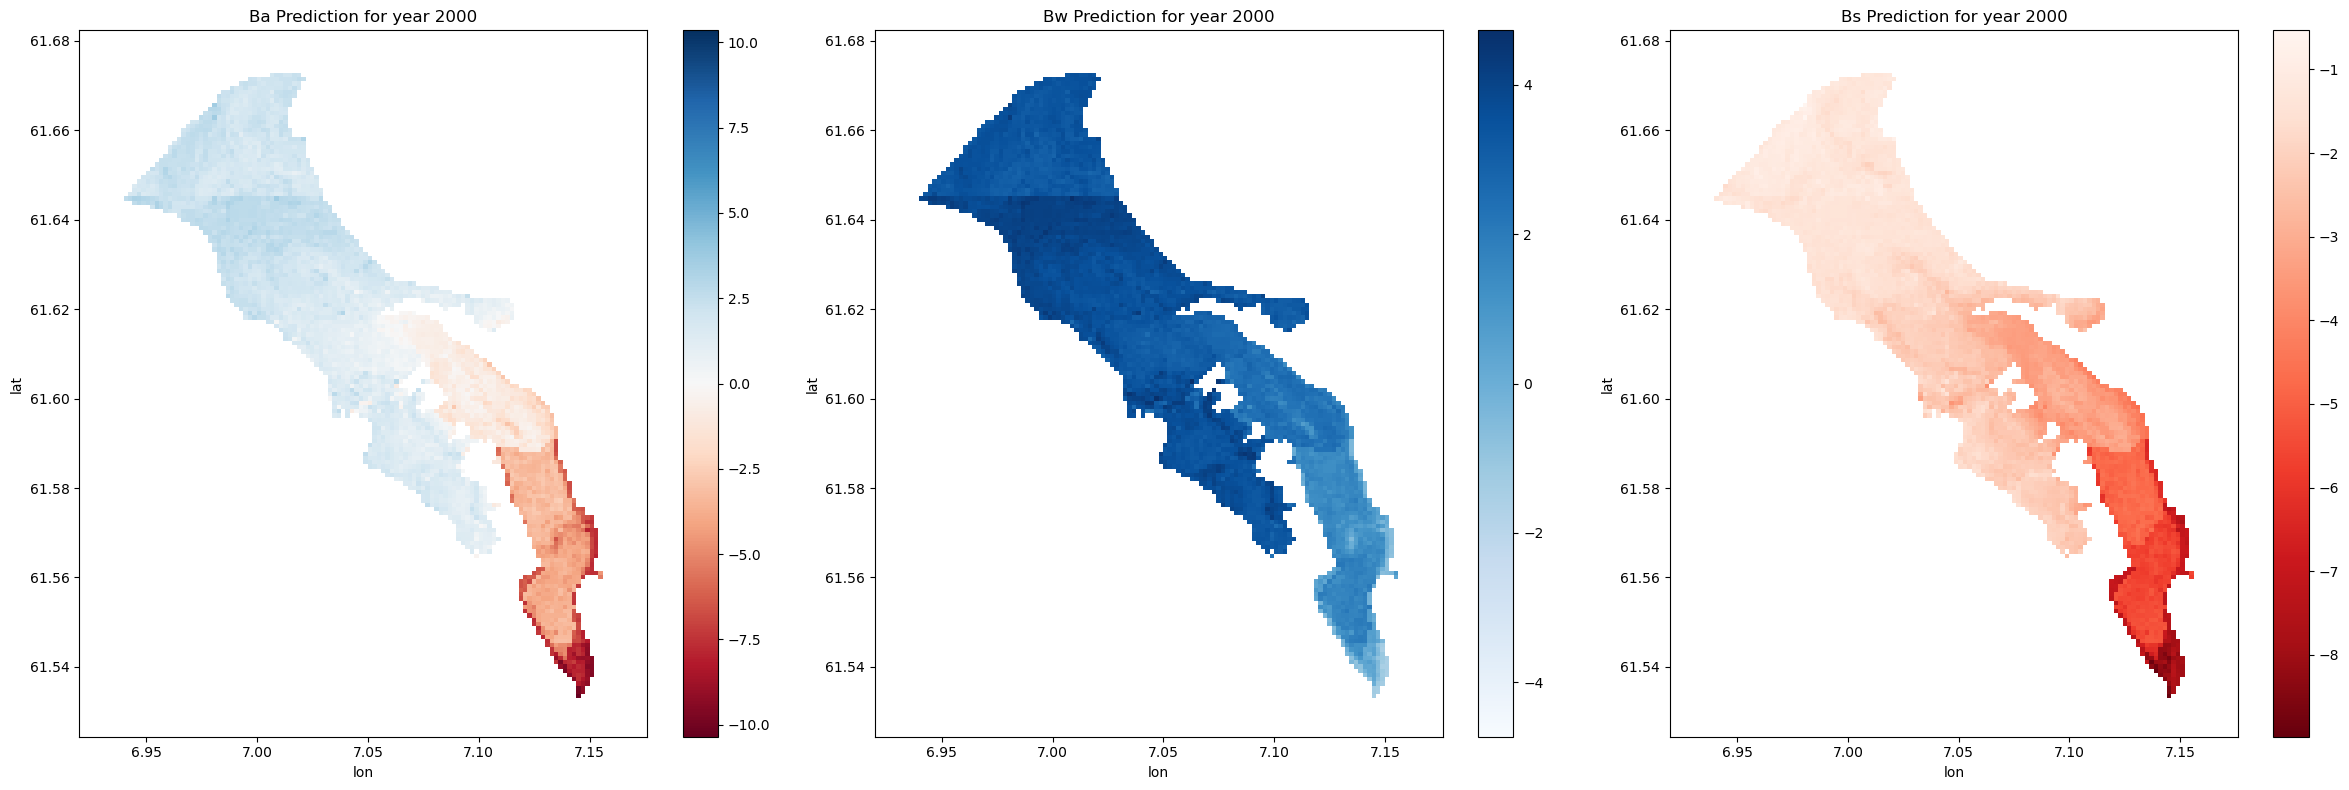

In [250]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

year = 200
pred_y_annual = df_pred[df_pred.year == year].drop(['year'], axis=1)

B_type = ['Ba', 'Bw', 'Bs']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), sharex=True)
for i in range(3):
    type_ = B_type[i]
    ds_pred_annual_latlon, ds_pred_annual_xy = predXarray(ds, pred_y_annual,  B_type[i])
    
    # Apply Gaussian filter
    smoothed_data = gaussian_filter(ds_pred_annual_latlon.pred_masked.values, sigma=0.1)
    
    # Create a new DataArray for plotting
    smoothed_dataarray = xr.DataArray(smoothed_data, coords=[ds_pred_annual_latlon.latitude, ds_pred_annual_latlon.longitude], dims=['lat', 'lon'])
    
    # Plot the smoothed data with the specified color map
    if type_ == 'Ba':
        smoothed_dataarray.plot(cmap='RdBu', ax=axes[i])
    elif type_ == 'Bw':
        smoothed_dataarray.plot(cmap='Blues', ax=axes[i])
    elif type_ == 'Bs':
        smoothed_dataarray.plot(cmap='Reds_r', ax=axes[i])
    
    axes[i].set_title(f'{type_} Prediction for year {year}')

plt.tight_layout()
plt.show()


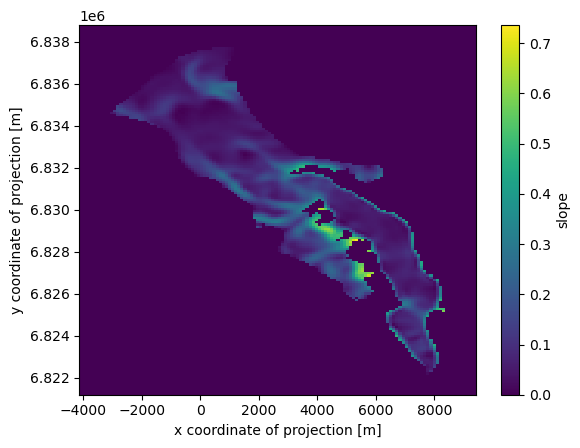

In [218]:
mask = ds.glacier_mask.values
slope_masked = ds.slope*mask

slope_masked.plot()

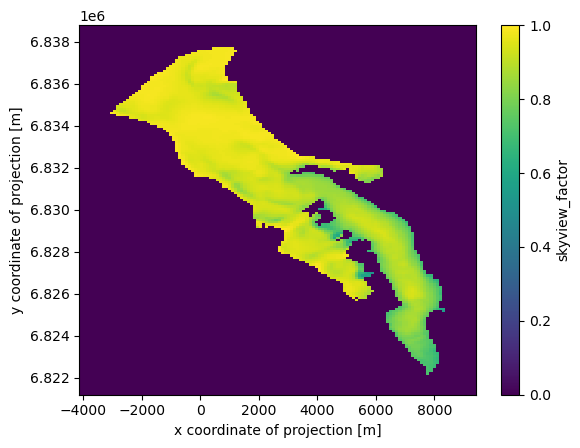

In [219]:
mask = ds.glacier_mask.values
svf_masked = ds.skyview_factor*mask

svf_masked.plot()

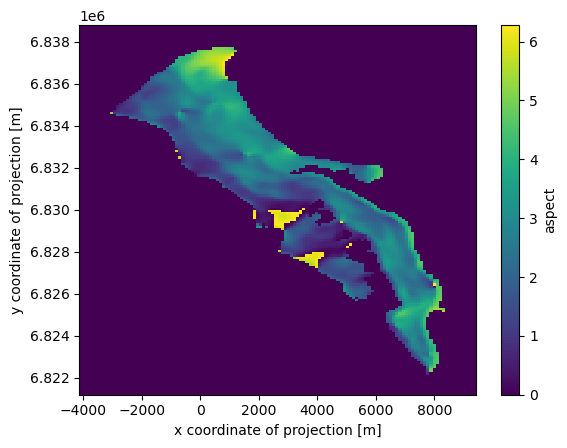

In [228]:
mask = ds.glacier_mask.values
aspect_masked = ds.aspect*mask

aspect_masked.plot()

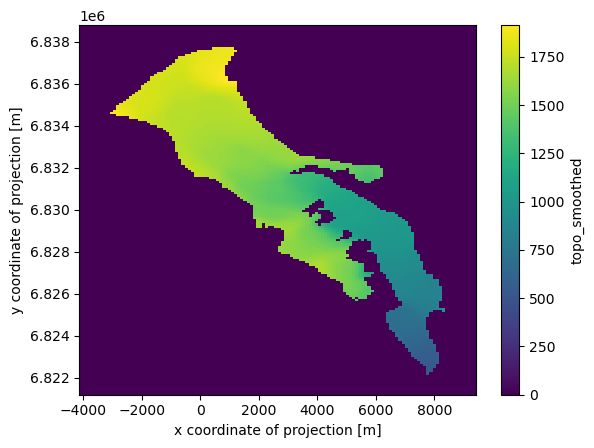

In [234]:
mask = ds.glacier_mask.values
topo_smooth_masked = ds.topo_smoothed*mask

topo_smooth_masked.plot()

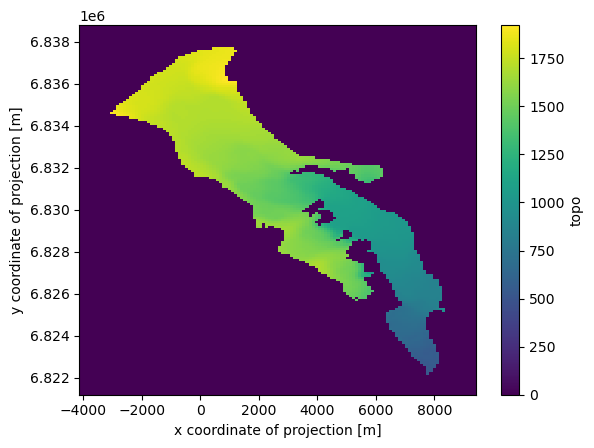

In [235]:
mask = ds.glacier_mask.values
topo_masked = ds.topo*mask

topo_masked.plot()